#Ensemble

This notebook is used to join the two models generated by the XceptionNet using the Xception_LION notebook. The two model are generated by using different weights on different classes in order to improve the accuracy on the 1st class.

#Setup

##Mouting Drive

In [ ]:

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


##Library
Importing all needed library.
We are also importing the preprocess function for the XceptionNet

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.xception import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import random
import os
import tensorflow as tf
from PIL import Image
import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

##Setting the seed for reproducibility

In [ ]:
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

##Unzipping the dataset

In [ ]:
!unzip -q '../gdrive/My Drive/ANNDL/Homework1/training_dataset_homework1.zip'

##Splitting the dataset
We have splitted the dataset in two part: 90% for the training and 10% for the validation. The validation is used only for Early stopping and the test was measured on Codalab hidden test

In [ ]:
import os
import random

!pip install split-folders

import splitfolders
dataset_dir = 'splitted'


# Split with a ratio.
splitfolders.ratio('training_data_final', output=dataset_dir, seed=seed, ratio=(.90, .10), group_prefix=None) # default values

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 3542 files [00:00, 7873.00 files/s]


#Preprocessing

##Printing examples

Setting the validation and the training folder.

Printing some examples for each species.

Plotting the number of images for each class present in the training set

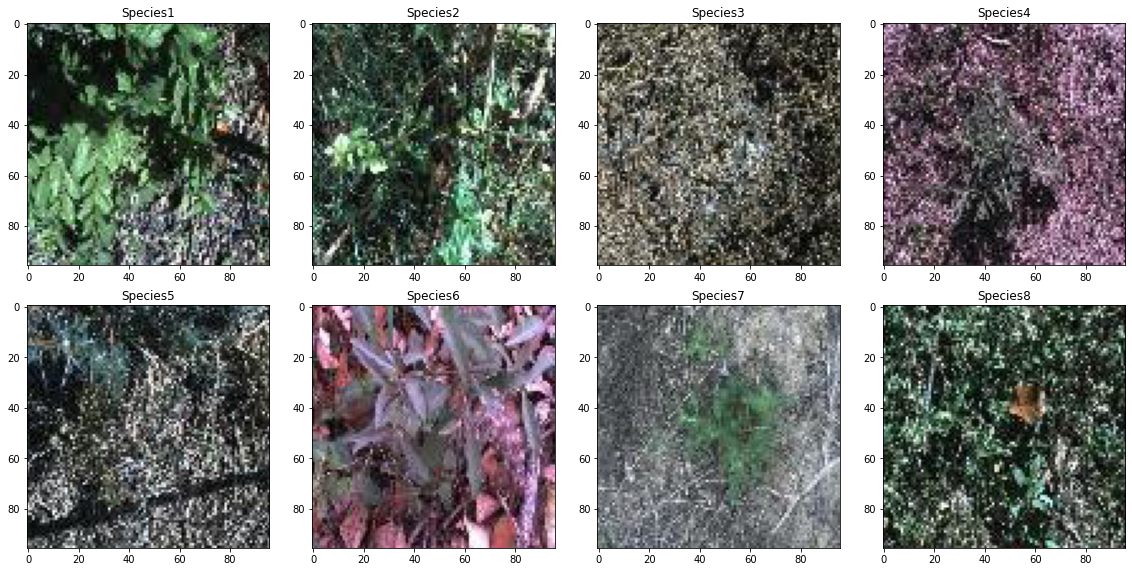

In [ ]:
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

# Plot example images from dataset
labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8']

from tensorflow.keras.utils import to_categorical



num_row = len(labels)//3
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(8*num_row,2*num_col))
for i in range(len(labels)):
  class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
  class_img = class_imgs[0]
  img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
  #print(np.array(img))
  ax = axes[i//num_col, i%num_col]
  ax.imshow(np.array(img))
  ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

483
{0: 2.8922155688622753, 1: 1.0104602510460252, 2: 1.043196544276458, 3: 1.0522875816993464, 4: 1.0125786163522013, 5: 2.4271356783919598, 6: 1.0, 7: 1.0568927789934355}


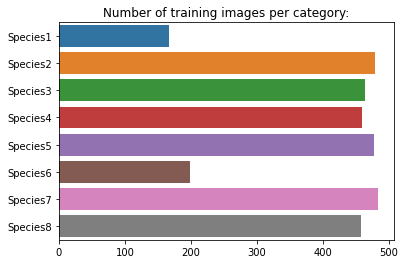

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
og_dataset = './splitted/train'
category_names = sorted(os.listdir(og_dataset))
nb_categories = len(category_names)
img_pr_cat = []
maxImgCat = 0
for category in category_names:
    folder = og_dataset + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
    if len(os.listdir(folder)) > maxImgCat:
      maxImgCat = len(os.listdir(folder))
print(maxImgCat)
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")
class_weight = {}
for i in range(len(labels)):
  path = "/content/splitted/train/Species"+str(i+1)
  class_weight[i] = maxImgCat/len(os.listdir(path))
print(class_weight)

#Augmentation
Adding augmentation over the training set

In [ ]:
# Create an instance of ImageDataGenerator with Data Augmentation
batch_size = 32

aug_train_data_gen = ImageDataGenerator(rotation_range=20,
                                        height_shift_range=0.2,
                                        width_shift_range=0.2,
                                        zoom_range=0.2,
                                        brightness_range=[0.9,1.5],
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        cval=0,
                                        preprocessing_function = preprocess_input,
                                        #rescale=1/255.
                                        ) # rescale value is multiplied to the image
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   # rotation_range=90,
                                   # height_shift_range=20,
                                   # width_shift_range=20,
                                   # zoom_range=0.5,
                                   # brightness_range=[0.9,1.5],
                                   # horizontal_flip=True,
                                    #vertical_flip=True, 
                                    #fill_mode='reflect',
                                    #cval=0,
                                    preprocessing_function = preprocess_input
                                    )
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       batch_size=batch_size,
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               batch_size=batch_size,
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=seed)
test_gen =valid_data_gen.flow_from_directory(directory=validation_dir,
                                             target_size=(96,96),
                                             batch_size=batch_size,
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             shuffle=False,
                                             seed=seed)

Found 3183 images belonging to 8 classes.
Found 359 images belonging to 8 classes.
Found 359 images belonging to 8 classes.


#Model Generation

##Callback
Adding the early stopping calculated over the validation set

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):
  callbacks = []
  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

##Importing the models

We are loading two different model:

1. XceptionNet with all correct weights
2. XceptionNet with more weight over the first class

Once the two models are loaded we put them together using a Concatenate layer from Keras. The resulting model has 16 outputs. At the end we add a Softmax layer with 8 neurons that is trained.




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Class1 (Functional)            (None, 8)            22967856    ['input_5[0][0]']                
                                                                                                  
 model (Functional)             (None, 8)            22967856    ['input_5[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 16)           0           ['Class1[0][0]',                 
                                                                  'model[0][0]']              

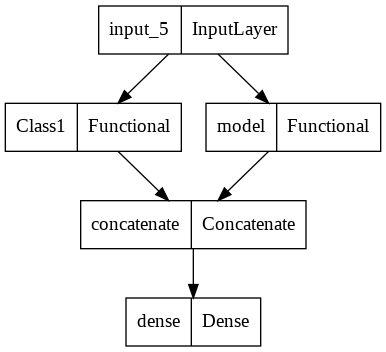

In [ ]:
from tensorflow.keras import regularizers

model_dir_1 = '/gdrive/MyDrive/ANNDL/Homework1/Models/Exception_1024_lion_retest_spinto_tuned'
model_dir_tot = '/gdrive/MyDrive/ANNDL/Homework1/Models/Exception1024_lion_tuned'

tl_callbacks = create_folders_and_callbacks(model_name = 'transfer_learning')

inputs = tfk.Input(shape=(96, 96, 3))

model = tf.keras.Sequential()
model.add(tfk.Input(shape=(96, 96, 3)))


model1 = tfk.models.load_model(model_dir_1)
model1._name='Class1'

#model1.summary()

a = model1(inputs)


# for i, layer in enumerate(model1.layers):
#   layer._name = 'class1_' + str(i)

model2 = tfk.models.load_model(model_dir_tot)(inputs)

# for i, layer in enumerate(model2.layers):
#   layer._name = 'tot_' + str(i)


x = tfk.layers.Concatenate()([a, model2])

output_layer = tfkl.Dense(units=8, activation='softmax')(x)

tl_model = tfk.Model(inputs, output_layer)
tl_model.get_layer('model').trainable = False
tl_model.get_layer('Class1').trainable = False

tl_model.compile(optimizer=tfk.optimizers.Adam(),
              loss=tfk.losses.CategoricalCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

tl_model.summary()
tfk.utils.plot_model(tl_model)

#Training the model

In [ ]:
# Train the model

tl_history = tl_model.fit(x = aug_train_gen, epochs=200, callbacks=tl_callbacks, validation_data=valid_gen, class_weight=class_weight)

Epoch 1/200
100/100 [==============================] - 37s 237ms/step - loss: 2.5162 - accuracy: 0.1495 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.8527 - val_accuracy: 0.1616 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
100/100 [==============================] - 21s 207ms/step - loss: 2.1772 - accuracy: 0.4901 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.6205 - val_accuracy: 0.6992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/200
100/100 [==============================] - 21s 211ms/step - loss: 1.8691 - accuracy: 0.8014 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4115 - val_accuracy: 0.8134 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/200
100/100 [==============================] - 21s 206ms/step - loss: 1.5969 - accuracy: 0.8992 - precision: 1.0000 - recall: 0.0258 - val_loss: 1.2280 - val_accuracy: 0.9053 - val_precision: 1.0000 - val_recall: 0.0836
Epoch 5/200
100/100 [===================

#Testing
Printing the confusion matrix 

12/12 [==============================] - 3s 180ms/step
[1 0 7 0 6 0 1 0 0 7 1 7 0 3 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 3 1 1 1 1 1 1 1 3 1 1 1 1 6 1 1 1 1 1 1 1 1 7 1 1 1 1 1 1 1 2
 2 2 2 2 2 2 2 2 2 2 2 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 4 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4
 3 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 2 4 4 4 4 2 4 4 4 4 4 4 4 4
 4 7 4 4 4 4 4 4 4 5 5 5 5 5 5 5 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 1 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 1 6 6 6 6 6 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 7 4 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 1 3 7
 7 7 7 7 7 6 7 7 1 7 7 7 7 7 7 7 7 7 7 1 4 7 7 7 7 7]
Accuracy: 0.9136
Precision: 0.9303
Recall: 0.8898
F1: 0.902


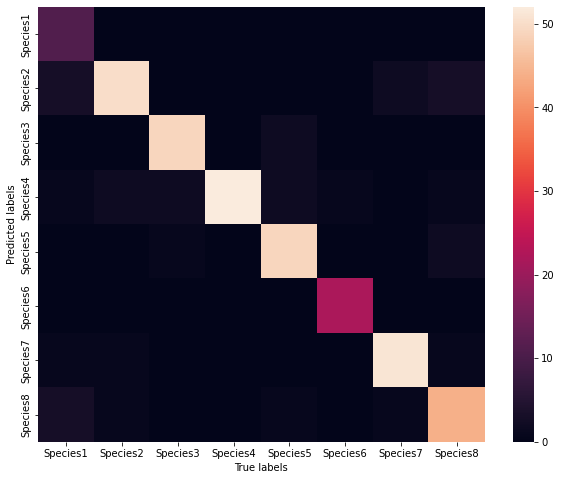

              precision    recall  f1-score   support

           0       1.00      0.58      0.73        19
           1       0.86      0.93      0.89        54
           2       0.96      0.94      0.95        52
           3       0.85      1.00      0.92        52
           4       0.94      0.91      0.92        54
           5       1.00      0.96      0.98        23
           6       0.94      0.94      0.94        54
           7       0.88      0.86      0.87        51

    accuracy                           0.91       359
   macro avg       0.93      0.89      0.90       359
weighted avg       0.92      0.91      0.91       359



In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=-1)
print(predicted_classes)

# Compute the confusion matrix

cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes, normalize = True)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

import sklearn.metrics
print(sklearn.metrics.classification_report(test_gen.classes, predicted_classes,output_dict = False))

#Saving the model

In [ ]:
model_dir = '/gdrive/MyDrive/ANNDL/Homework1/Models/Exception_1024_lion_retest_spinto_double_soft_sub'
tl_model.save(model_dir)